# Cluster NLU results

This notebook demonstrates clustering sample customer message using the results from Watson Natural Language Understanding.

1. Import saved analysis results
2. Cluster results

## Import saved analysis results

To import the saved data into this notebook, click on the empty cell below and then perform these steps:
1. Open the data panel by clicking on the **Find and Add Data** icon ( <img style="margin: 0px; padding: 0px; display: inline;" src="https://github.com/spackows/CASCON-2019_NLP-workshops/raw/master/images/find-add-data-icon.png"/> )
2. Under the file named <code>NLU-results-custom-model-normalized.json</code> click **Insert to code**
3. Select "Insert Credentials"

In [235]:
# Define a helper function for copying files from  
# Project storage to the notebook working directory
#

from ibm_botocore.client import Config
import ibm_boto3

def download( credentials ):
    cos = ibm_boto3.client(
        service_name='s3',
        ibm_api_key_id=credentials['IBM_API_KEY_ID'],
        ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
        ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
        config=Config(signature_version='oauth'),
        endpoint_url=credentials['ENDPOINT'])
    cos.download_file(Bucket=credentials['BUCKET'],Key=credentials['FILE'],Filename=credentials['FILE'])
    print( "Done: '" + credentials['FILE'] + "'" )

In [236]:
download( credentials_1 )

Done: 'NLU-results-custom-model-normalized.json'


In [237]:
import json
with open( credentials_1['FILE'] ) as json_file:
    results_list = json.load(json_file)
results_list[0:3]

[{'header': '-------------------------------------------------------------',
  'message': 'Good morning can you help me upload a shapefile?',
  'actions': ['load'],
  'objects': ['shapefile'],
  'tech': [],
  'docs': [],
  'persona': [],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'Good night where to place my file to import it into notebook?',
  'actions': ['import'],
  'objects': ['notebook'],
  'tech': [],
  'docs': [],
  'persona': [],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'hai how can i do analyze with csv file is there any tutorial on it',
  'actions': ['analyze'],
  'objects': [],
  'tech': [],
  'docs': ['tutorial'],
  'persona': [],
  'spacer': ''}]

## Cluster results

Use _dendrograms_ to cluster sample messages using the "actions", "objects", or "technology" entities extracted from the messages using Watson Natural Language Understanding with our custom laguage model.

See: [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)


In [238]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy import cluster

def listUnique( given_list, keys_arr ):
    unique_words = []
    for key in keys_arr:
        for result in given_list:
            words_arr = result[key]
            for word in words_arr:
                if word not in unique_words:
                    unique_words.append( word )
    return sorted( unique_words )

def buildMatrix( given_list, keys_arr ):
    unique_words = listUnique( given_list, keys_arr )
    messages = []
    labels = []
    matrix = []
    for i in range(len(given_list)):
        result = given_list[i]
        message = result["message"]
        label_arr = []
        row = []
        for key in keys_arr:
            words_arr = result[key]
            for word in unique_words:
                if word in words_arr:
                    label_arr.append( word )
                    row.append( 1 )
                else:
                    row.append( 0 )
        if( len( label_arr ) > 0 ):
            messages.append( message )
            labels.append( " | ".join( label_arr ) )
            matrix.append( row )
    return messages, labels, matrix

def listGroups( messages, Z, labels ):
    cutree = cluster.hierarchy.cut_tree( Z, height=1.25 )
    groups = {}
    for i in range( len(cutree) ):
        group_num_str = str( cutree[i][0] )
        message = messages[i]
        label = labels[i]
        if group_num_str not in groups:
            groups[group_num_str] = { "labels" : [], "messages" : [] }
        groups[group_num_str]["labels"].append(label)
        groups[group_num_str]["messages"].append(message)
    return groups        

def createDendrogram( messages, labels, matrix ):
    Z = linkage( matrix, 'single')
    plt.figure( figsize=( 5, 30 ) )
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    dend = dendrogram( Z,
                       get_leaves=True,
                       orientation='left',
                       labels=labels,
                       leaf_font_size=12,
                       show_leaf_counts=True)
    plt.show()
    groups = listGroups( messages, Z, labels )
    return groups, dend

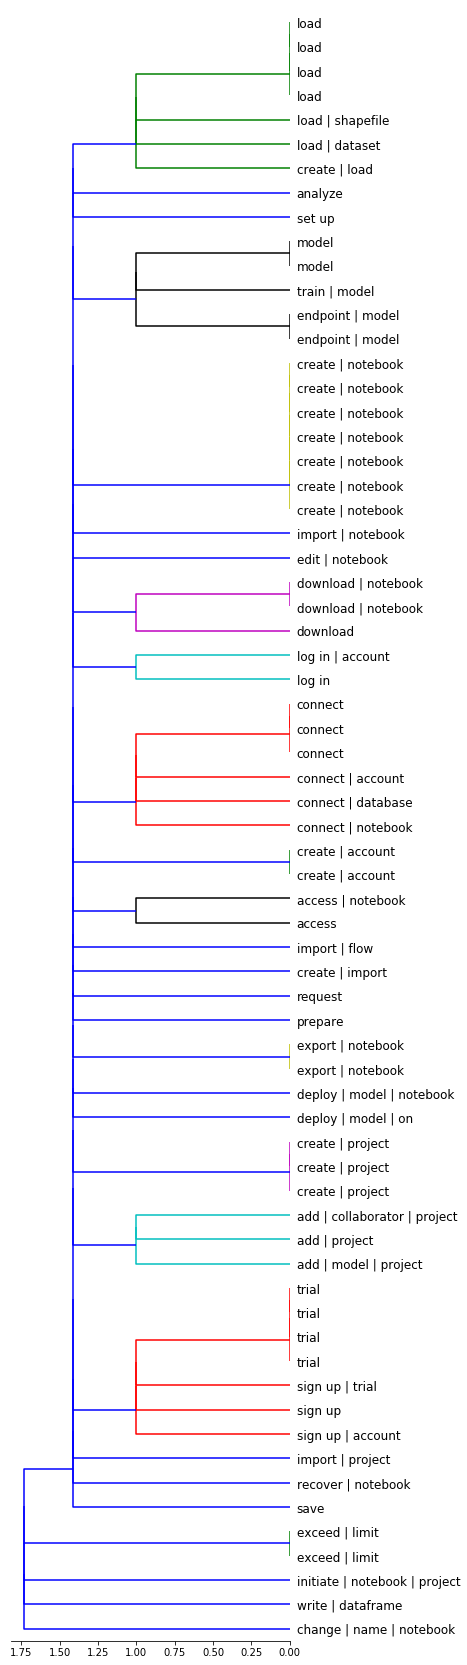

In [248]:
actions_objs_messages, actions_objs_labels, actions_objs_matrix = buildMatrix( results_list, [ "actions", "objects" ] )
actions_objs_groups, actions_objs_dend = createDendrogram2( actions_objs_messages, actions_objs_labels, actions_objs_matrix )

In [249]:
print( json.dumps( actions_objs_groups, indent=3 ) )

{
   "0": {
      "labels": [
         "load | shapefile",
         "load",
         "load",
         "load",
         "load | dataset",
         "create | load",
         "load"
      ],
      "messages": [
         "Good morning can you help me upload a shapefile?",
         "Hello Im trying to upload one 1.5GB tar.gz file and unzip to Object Storage. Could you tell me how to do it?",
         "Hi fine I was having difficulty uploading data but its working now",
         "Hi there how can I upload a series of .zip files then unzip them?",
         "How to upload a dataset from local to RStudio",
         "Im following the example it says that I can upload to spark but when I try it says unable to create a new link what am I doing wrong?",
         "Uploading data from object storage to rstudio returns an error"
      ]
   },
   "1": {
      "labels": [
         "import | notebook"
      ],
      "messages": [
         "Good night where to place my file to import it into notebook?"
  

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.